In [15]:
import importlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from pathlib import Path
import numpy as np
import pandas as pd
from scipy.special import expit
import scipy.stats

from mapra import prep

from multiprocessing import Process
from time import sleep

import sklearn
from sklearn import linear_model, metrics
from sklearn.metrics import auc, plot_roc_curve, mean_squared_error, r2_score, matthews_corrcoef
from sklearn.model_selection import train_test_split, StratifiedKFold

sns.set_theme(style='white')


def save(fig, path):
    wd = Path('.').resolve().parent / 'plots'
    Path.mkdir(wd, parents=True, exist_ok=True)
    fig.savefig(wd / path, dpi=300, bbox_inches=0)

cosine similarity
multiply the cosines distances

or feed both values into an NN

In [16]:
importlib.reload(prep)
data = prep.dataset()
npr = data.fetch_numpy_distances()
delta_labels = data.order
'''
The first column indicates the metric,
the second the value,
the rest is the embedding diff
'''

/home/quirin/PYTHON/mapra


/home/quirin/PYTHON/mapra/mapra/prep.py:37: RuntimeWarning: unexpected FASTA filename: /home/quirin/PYTHON/mapra/all_sequences_prothermdb.fasta
  warnings.warn('unexpected FASTA filename: ' + str(fasta), RuntimeWarning)


loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


'\nThe first column indicates the metric,\nthe second the value,\nthe rest is the embedding diff\n'

In [17]:
spears = dict()
for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spears[delta] = spear[0, 1:]
spears

{'dtemp': array([ 0.11917816,  0.08558531,  0.15808247, ..., -0.0420155 ,
         0.04407386, -0.07219054]),
 'ddg': array([ 0.02027241,  0.04867881,  0.21048373, ..., -0.01711015,
        -0.01872658, -0.07774655]),
 'h2o': array([ 0.09248193,  0.19152187,  0.22394765, ..., -0.0162556 ,
         0.10900918, -0.13531456])}

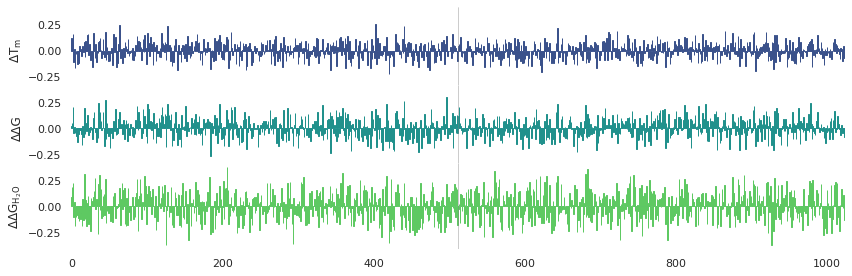

In [18]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, (delta, spear_row), color in zip(
        axes, spears.items(), sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    ax.bar(x=list(range(1024)), height=spear_row,
           edgecolor=color, label=delta)
ax.set_xlim(-1, 1024)

for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

save(fig, f'spearman_cor_h5_matplotlib.png')

In [19]:
spd = pd.DataFrame()
spd['x'] = range(1024)

for i, delta in enumerate(delta_labels):
    # select only matching rows, and ignore the delta column
    dnpr = npr[npr[:, 0] == i, 1:]
    spear, pval = scipy.stats.spearmanr(dnpr, axis=0)
    # only need first line[1:] of output matrix
    spd[delta] = spear[0, 1:]

In [20]:
corr_corr = spd.loc[:, delta_labels].corr(method='spearman')
corr_corr

,dtemp,ddg,h2o
dtemp,1.000000,0.768764,0.444120
ddg,0.768764,1.000000,0.530728
h2o,0.444120,0.530728,1.000000


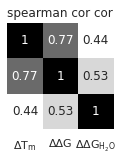

In [21]:
f, ax = plt.subplots(1, 1, figsize=(2.4, 2.4))
labs = [data.tex_lookup[delta] for delta in delta_labels]
g = sns.heatmap(corr_corr, annot=True, cmap='binary', cbar=False, square=True, ax=ax,
                xticklabels=labs, yticklabels=False)
g.set(title='spearman cor cor')
f.tight_layout()
save(f, f'spearman_cor_cor.png')

In [22]:
spd = spd.melt(id_vars='x', var_name='delta', value_name='y')
spd


,x,delta,y
0,0,dtemp,0.119178
1,1,dtemp,0.085585
2,2,dtemp,0.158082
3,3,dtemp,-0.108385
4,4,dtemp,0.011450
...,...,...,...
3067,1019,h2o,0.172391
3068,1020,h2o,0.019401
3069,1021,h2o,-0.016256
3070,1022,h2o,0.109009


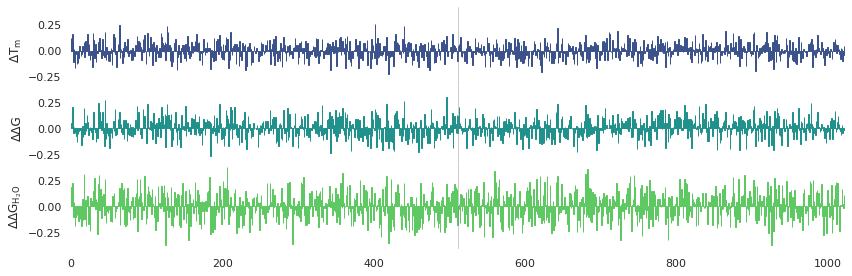

In [23]:
fig, axes = plt.subplots(3, 1, figsize=(12, 4), sharex=True, sharey=True)
for ax, delta, color in zip(
        axes, delta_labels, sns.color_palette('viridis', 3)):
    ax.axvline(x=512, lw=.5, color='.5', alpha=.8)
    sns.barplot(data=spd.loc[spd.delta == delta],
                x='x', y='y', ax=ax,
                facecolor=color,
                linewidth=1, edgecolor=color)
for delta, ax in zip(delta_labels, axes.flatten()):
    ax.set(ylabel=data.tex_lookup[delta], xlabel='')

axes[2].set(xticks=[i for i in range(1024) if not i % 200])
sns.despine(fig, left=True, bottom=True)
fig.tight_layout()
fig.subplots_adjust(hspace=-.1)

save(fig, f'spearman_cor_h5.png')

### Try predicting from the vector length, maybe that's better than adding up pairwise distances

In [24]:
sns.set_theme(style='white')

# use all that stuff from the 4b_logit notebook
extend = 0
func = sum
modify = 'abs'
metric = 'euclidean'
thresholds = [3, 1, 1.5]
# even the old dataframe
mbeds = data.fetch_df_with_pairwise_distances(extend=extend, modify=modify, func=func)
# metric = 'euclidean'
df = mbeds.data.loc[(mbeds.data.metric == mbeds.metric_labels.index(metric)),
                    [c for c in mbeds.data.columns if c != 'metric']]
df

loading from /home/quirin/PYTHON/mapra/pkl/h5_slice_0.pkl


,delta,dist,change
0,0,6.147786,9.9
1,0,4.140685,2.3
2,0,3.226287,3.6
3,0,3.282363,1.0
4,0,11.105935,5.6
...,...,...,...
26158,2,3.403326,0.6
26159,2,3.403326,1.1
26160,2,3.717135,0.9
26161,2,3.717135,1.1


In [25]:
# but replace the sum of pqirwise dists with the diff sum vector length
df.dist = np.linalg.norm(npr[:, 2:], axis=1)
df

,delta,dist,change
0,0,6.148438,9.9
1,0,4.140625,2.3
2,0,3.226562,3.6
3,0,3.283203,1.0
4,0,6.476562,5.6
...,...,...,...
26158,2,3.404297,0.6
26159,2,3.404297,1.1
26160,2,3.716797,0.9
26161,2,3.716797,1.1


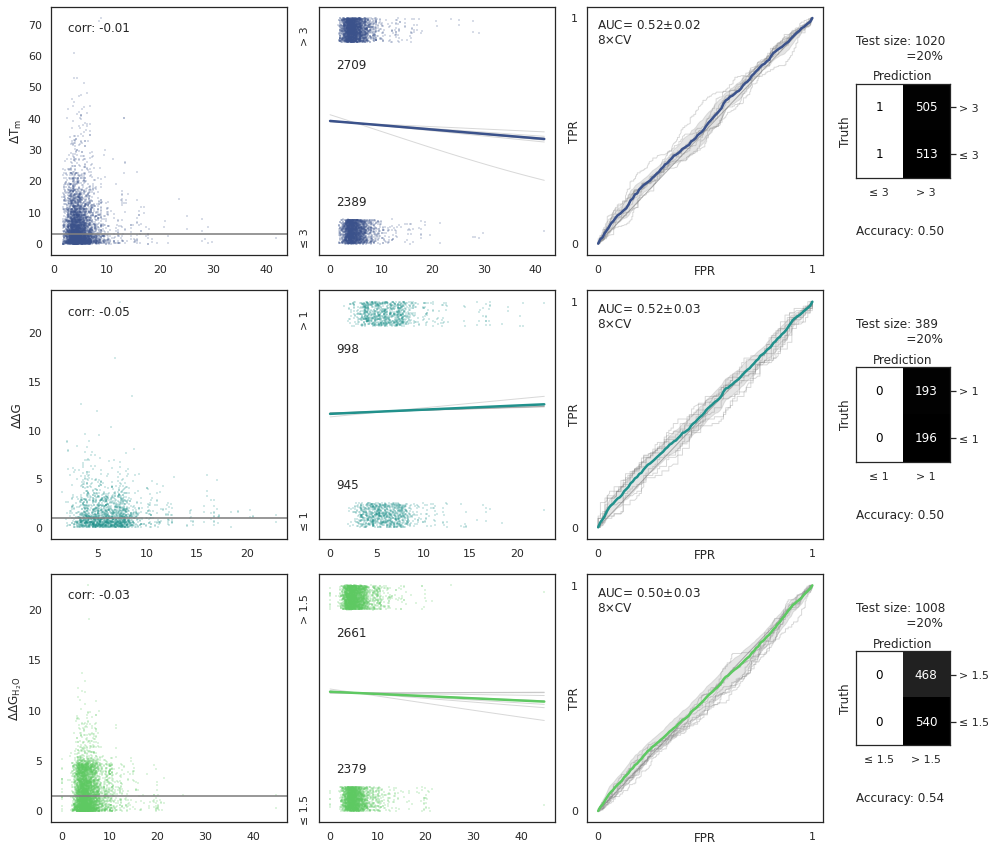

In [26]:
# # create class labels
# thresholds = [3, 1, 1.5]
df['label'] = df.apply(lambda gdf: 0 if abs(gdf.change) <= thresholds[int(gdf.delta)] else 1, axis=1)

# plotting prep
fig, axs = plt.subplots(3, 4, figsize=(14, 12), gridspec_kw={'width_ratios': [1, 1, 1, .4]})
cmap = sns.color_palette('viridis', 3)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = list(), list()
test_size = .2

for i, delta in enumerate(mbeds.delta_labels):
    # select the records for this delta
    dfn = df.loc[df.delta == i]

    sns.regplot(data=dfn,
                ax=axs[i, 0],
                x='dist', y='change',
                color=cmap[i],
                marker='+',
                scatter_kws={'s': 3, 'alpha': .2},
                fit_reg=False, logistic=True)
    axs[i, 0].set(ylabel=data.tex_lookup[delta], xlabel='')
    axs[i, 0].axhline(y=thresholds[i], lw=2, color='.5', alpha=.8)

    # make the scatterplot
    sns.regplot(data=dfn,
                ax=axs[i, 1],
                x='dist', y='label',
                marker='+',
                y_jitter=.06, color=cmap[i],
                scatter_kws={'s': 3, 'alpha': .2},
                fit_reg=False, logistic=True)
    axs[i, 1].set(xlabel='', yticks=[0, 1], ylabel='',
                  yticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'])
    axs[i, 1].tick_params(axis='y', labelrotation=90)
    axs[i, 1].yaxis.labelpad = -10

    # fetch the training data
    X, y = np.array(dfn['dist']).reshape(-1, 1), np.array(dfn['label'])

    # split into test and training data
    X, x_test, y, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42)

    n_splits = 8
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    clf = linear_model.LogisticRegressionCV(random_state=42,
                                            cv=cv,  # use existing splitter
                                            refit=True)  # build best model in the end

    for j, (train, test) in enumerate(cv.split(X, y)):
        clf.fit(X[train], y[train])

        # plot a ROC curve
        viz = plot_roc_curve(clf, X[test], y[test], lw=1, color='.5', alpha=.3, ax=axs[i, 2])
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

        # plot the loss curves
        x_line = np.linspace(0, max(X), 100)
        loss = expit(x_line * clf.coef_ + clf.intercept_).ravel()
        axs[i, 1].plot(x_line, loss, lw=1, color='.5', alpha=.3)

    # correlations
    pearson_corr = np.corrcoef(dfn[['dist', 'change']], rowvar=False)[0, 1]
    axs[i, 0].text(.07, .9, f'corr: {pearson_corr:.2f}', transform=axs[i, 0].transAxes)

    # label class sizes
    axs[i, 1].text(.07, .75, f'{len(dfn.loc[dfn.label == 1]):.0f}', transform=axs[i, 1].transAxes)
    axs[i, 1].text(.07, .20, f'{len(dfn.loc[dfn.label == 0]):.0f}', transform=axs[i, 1].transAxes)

    # plot the overall loss curve
    x_line = np.linspace(0, max(X), 100)
    loss = expit(x_line * clf.coef_ + clf.intercept_).ravel()
    axs[i, 1].plot(x_line, loss, lw=2.5, color=cmap[i], alpha=1)

    # plot the diagonal
    axs[i, 2].plot([0, 1], [0, 1], lw=1, color='.5', alpha=.6)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    axs[i, 2].plot(mean_fpr, mean_tpr, color=cmap[i], lw=2.5, alpha=1)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    axs[i, 2].fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2)

    axs[i, 2].set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])  #, title="Receiver operating characteristic example")
    axs[i, 2].text(.04, .85, f'AUC= {mean_auc:0.2f}$\pm${std_auc:.2f}\n{n_splits}×CV', transform=axs[i, 2].transAxes)
    axs[i, 2].get_legend().remove()
    axs[i, 2].set(xlabel='FPR', ylabel='TPR', xticks=[0, 1], yticks=[0, 1])
    axs[i, 2].xaxis.labelpad = -10
    axs[i, 2].yaxis.labelpad = -10

    # make final test
    f = metrics.plot_confusion_matrix(clf, x_test, y_test, ax=axs[i, 3],
                                      cmap='binary', colorbar=False)
    axs[i, 3].yaxis.tick_right()
    axs[i, 3].xaxis.set_label_position('top')

    axs[i, 3].set(ylabel='Truth', xlabel='Prediction',
                  xticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'],
                  yticklabels=[f'≤ {thresholds[i]}', f'> {thresholds[i]}'][::-1])

    axs[i, 3].text(0, 1.1, f'Test size: {len(x_test)}\n             ={test_size * 100:.0f}%\n',
                   transform=axs[i, 3].transAxes)
    axs[i, 3].text(0, -.6, f'Accuracy: {clf.score(x_test, y_test):.2f}',
                   transform=axs[i, 3].transAxes)

wd = Path('.').resolve().parent / 'plots' / 'comp'
Path.mkdir(wd, parents=True, exist_ok=True)
fig.tight_layout()
fig.savefig(
    wd / f'df_numpy_dist_euclidean_{1 + 2 * extend}_{modify}_{func.__name__}_{"-".join([str(t) for t in thresholds])}.png',
    dpi=300, bbox_inches=0)


In [27]:
npr


array([[ 0.0000e+00,  9.8984e+00, -9.8877e-02, ...,  2.8412e-02,
         3.3936e-02,  5.3711e-03],
       [ 0.0000e+00,  2.3008e+00,  1.5015e-02, ..., -3.9917e-02,
        -1.0040e-01, -1.1914e-01],
       [ 0.0000e+00,  3.5996e+00, -7.5806e-02, ...,  1.4893e-02,
        -1.6138e-01,  6.3477e-02],
       ...,
       [ 2.0000e+00, -8.9990e-01, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00, -1.0996e+00, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01],
       [ 2.0000e+00,  9.9976e-02, -1.3513e-01, ..., -3.2227e-02,
        -1.0156e-01,  1.6956e-01]], dtype=float16)

### multivariate log/lin regression

dtemp
COEF [[ 0.59433746 -3.9592428   1.0431926  ... -1.4746472  -1.0095527
   1.9372718 ]]
RMSE 5.4143524169921875
R2 0.622980814792356

spearman [[ 1.00000000e+00  1.19178157e-01  8.55853088e-02 ... -4.20154963e-02
   4.40738597e-02 -7.21905435e-02]
 [ 1.19178157e-01  1.00000000e+00  2.40719497e-01 ... -2.78791515e-02
  -4.92899857e-02  8.33227746e-04]
 [ 8.55853088e-02  2.40719497e-01  1.00000000e+00 ...  2.51605224e-02
  -2.53990162e-02  1.17835385e-01]
 ...
 [-4.20154963e-02 -2.78791515e-02  2.51605224e-02 ...  1.00000000e+00
  -8.63143404e-02 -2.52017523e-02]
 [ 4.40738597e-02 -4.92899857e-02 -2.53990162e-02 ... -8.63143404e-02
   1.00000000e+00  2.93082744e-02]
 [-7.21905435e-02  8.33227746e-04  1.17835385e-01 ... -2.52017523e-02
   2.93082744e-02  1.00000000e+00]]
ddg
COEF [[-0.79502195  1.1264238  -1.3809719  ... -1.6727394   0.04336345
   0.5803896 ]]
RMSE 0.625861406326294
R2 0.9153799495896814

spearman [[ 1.          0.02027241  0.04867881 ... -0.01711015 -0.01872658
  -0.

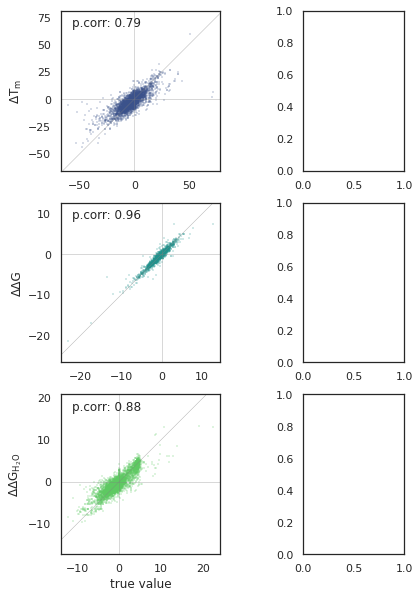

In [84]:
# plotting prep
fig, axs = plt.subplots(3, 2, figsize=(7, 10), gridspec_kw={'width_ratios': [1, .4]})
cmap = sns.color_palette('viridis', 3)
mean_fpr = np.linspace(0, 1, 100)
tprs, aucs = list(), list()

test_size = .2

for i, delta in enumerate(delta_labels):
    # select the rows for this delta, and cleave off the delta column
    dnpr = npr[npr[:, 0] == i, 1:]

    # split into features and labels
    X, y = dnpr[:, 1:], dnpr[:, 0].reshape(-1, 1)

    # split into test and training data
    X, X_test, y, y_true = X, X, y, y
    # X, X_test, y, y_true = train_test_split(
    #     X, y, test_size=test_size)  #, random_state=42)

    regr = linear_model.LinearRegression()
    regr.fit(X, y)
    print(delta)
    print(f'COEF {regr.coef_}')
    y_pred = regr.predict(X_test)
    print(f'RMSE {mean_squared_error(y_true, y_pred, squared=False)}')
    print(f'R2 {r2_score(y_true, y_pred)}\n')
    # print(f'MCC {matthews_corrcoef(y_true, y_pred)}\n')
    print(f'spearman {scipy.stats.spearmanr(dnpr, axis=0)[0]}')

    axs[i, 0].set(ylabel=data.tex_lookup[delta], xlabel='', aspect=1, box_aspect=1)
    axs[i, 0].axhline(y=0, lw=.5, color='.5', alpha=.6)
    axs[i, 0].axvline(x=0, lw=.5, color='.5', alpha=.6)
    axs[i, 0].axline((0, 0), slope=1, lw=.5, color='.5', alpha=.6)
    axs[i, 0].text(.07, .9, f'p.corr: {np.corrcoef(np.hstack((y_true, y_pred)), rowvar=False)[0, 1]:.2f}',
                   transform=axs[i, 0].transAxes)

    sns.regplot(ax=axs[i, 0],
                x=y_true, y=y_pred,
                color=cmap[i],
                marker='+',
                scatter_kws={'s': 3, 'alpha': .2},
                fit_reg=False, logistic=True)

axs[2, 0].set(xlabel='true value')
save(fig, 'linear_regr_1.png')

array([[-14.5       , -11.70779   ],
       [ -0.30004883,  -1.3121841 ],
       [  1.9003906 ,  12.009673  ],
       ...,
       [ -0.30004883,  -0.5912626 ],
       [  4.8007812 ,   6.973675  ],
       [ -0.09997559,  -3.0718474 ]], dtype=float32)

### talk
don't CV
linear regression on `abs` of labels

use LogisticRegressionCV to predict a < -1 , -1 <= a <= 1, 1 < a labels

try with abs!

try [PolynomialFeatures](https://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions)

discretize y_test and y_pred to use [MCC](https://scikit-learn.org/stable/modules/model_evaluation.html#matthews-correlation-coefficient)?

[Regression metrics](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics)

R² score ~ goodness of fit. to compare how well a regression fits to the different metrics, but is not comparable outside of the dataset

compare to a [dummy estimator](https://scikit-learn.org/stable/modules/model_evaluation.html#dummy-estimators)

use LASSO when there are few important features. However, it looks like we have many meaningful positions? Meaning those with correlations not close to 0.

LinearRegression calculates ordinary least squares

a [Perceptron](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Perceptron.html#sklearn.linear_model.Perceptron) is a binary classifier :(

In [29]:
dnpr[:, 0].reshape(-1, 1).shape

(5040, 1)